In [19]:
import pandas as pd
import networkx
import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import output_notebook, show, save
from pathlib import Path
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [2]:
output_notebook()

Loading BokehJS ...

In [5]:
%pwd

'/Users/annasintsova/git_repos/nguyenb_tnseq/code/notebooks/08_2021_pathway_enrichment'

In [15]:
# Load the final results table

results_full = pd.read_csv("../../../data/results/26-07-final-results.csv", index_col=0)

# Separate by day and write all hits for each day into a tsv file
# Using shortNames for this
results_hits = results_full[results_full.zscore_padj < 0.05]
for day in results_hits.day.unique():
    df = results_hits[results_hits.day == day]
    genes = [gene for gene in df.gene.unique() if len(gene)<10]
    with open(f"../../../data/results/29-09-hits-{day}.tsv", 'w') as fo:
        for gene in genes:
            fo.write(f"{gene}\n")

In [16]:
# Run through STRING, right now manual, could work on API

In [95]:
# Colors
vmin= -3
vmax=0.5
cmap = plt.cm.coolwarm
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap,norm=divnorm)

In [120]:
def get_graph_for_cluster(results_df, cluster_df, interaction_df, day='d1', cluster=1):
    results = results_df[results_df.day == day].copy()
    results['logCI'] = np.log10(results['CI'])
    cl_genes = list(cluster_df[cluster_df['cluster_number'] == cluster]["protein_name"].values)
    #dtg = interaction_df[(interaction_df.node1.isin(cl_genes)) | (interaction_df.node2.isin(cl_genes))][['node1', 'node2', 'combined_score']]
    dtg = interaction_df[(interaction_df.node1.isin(cl_genes)) & (interaction_df.node2.isin(cl_genes))][['node1', 'node2', 'combined_score']]
    genes_in_graph = set(list(dtg.node1.unique())+ list(dtg.node2.unique())).intersection(results.gene)
    in_cluster = {c:2000 if c in cl_genes else 500 for c in genes_in_graph}
    dtg = dtg[(dtg.node1.isin(genes_in_graph)) & (dtg.node2.isin(genes_in_graph))]
    ci = results[results.gene.isin(genes_in_graph)].set_index('gene').to_dict()['logCI']
    G = networkx.from_pandas_edgelist(dtg, 'node1', 'node2', 'combined_score')
    edge_width = dict([((a, b), G.get_edge_data(a,b)['combined_score']*5) for a, b in G.edges()])
    networkx.set_edge_attributes(G, name ="edge_width", values =edge_width)
    networkx.set_node_attributes(G, name='day_ci', values=ci)
    networkx.set_node_attributes(G, name='in_cluster', values=in_cluster)
    return G

In [152]:
import networkx as nx
def plot_cluster(graph, ax, sm):
    pos = nx.kamada_kawai_layout(graph)
    edge_width = list(nx.get_edge_attributes(graph, 'edge_width').values())
    node_size = list(networkx.get_node_attributes(graph, 'in_cluster').values())
    ncolor = list(networkx.get_node_attributes(graph, 'day_ci').values())
    ncolor = [sm.to_rgba(x) for x in ncolor]
    nx.draw_networkx_edges(graph, pos, alpha=0.8, width=edge_width, ax=ax )
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=ncolor,  
                         alpha=0.9, ax=ax)
    label_options = {"ec": "k", "fc": "white", "alpha": 0.5}
    nx.draw_networkx_labels(graph, pos, font_size=16, bbox=label_options, ax=ax);

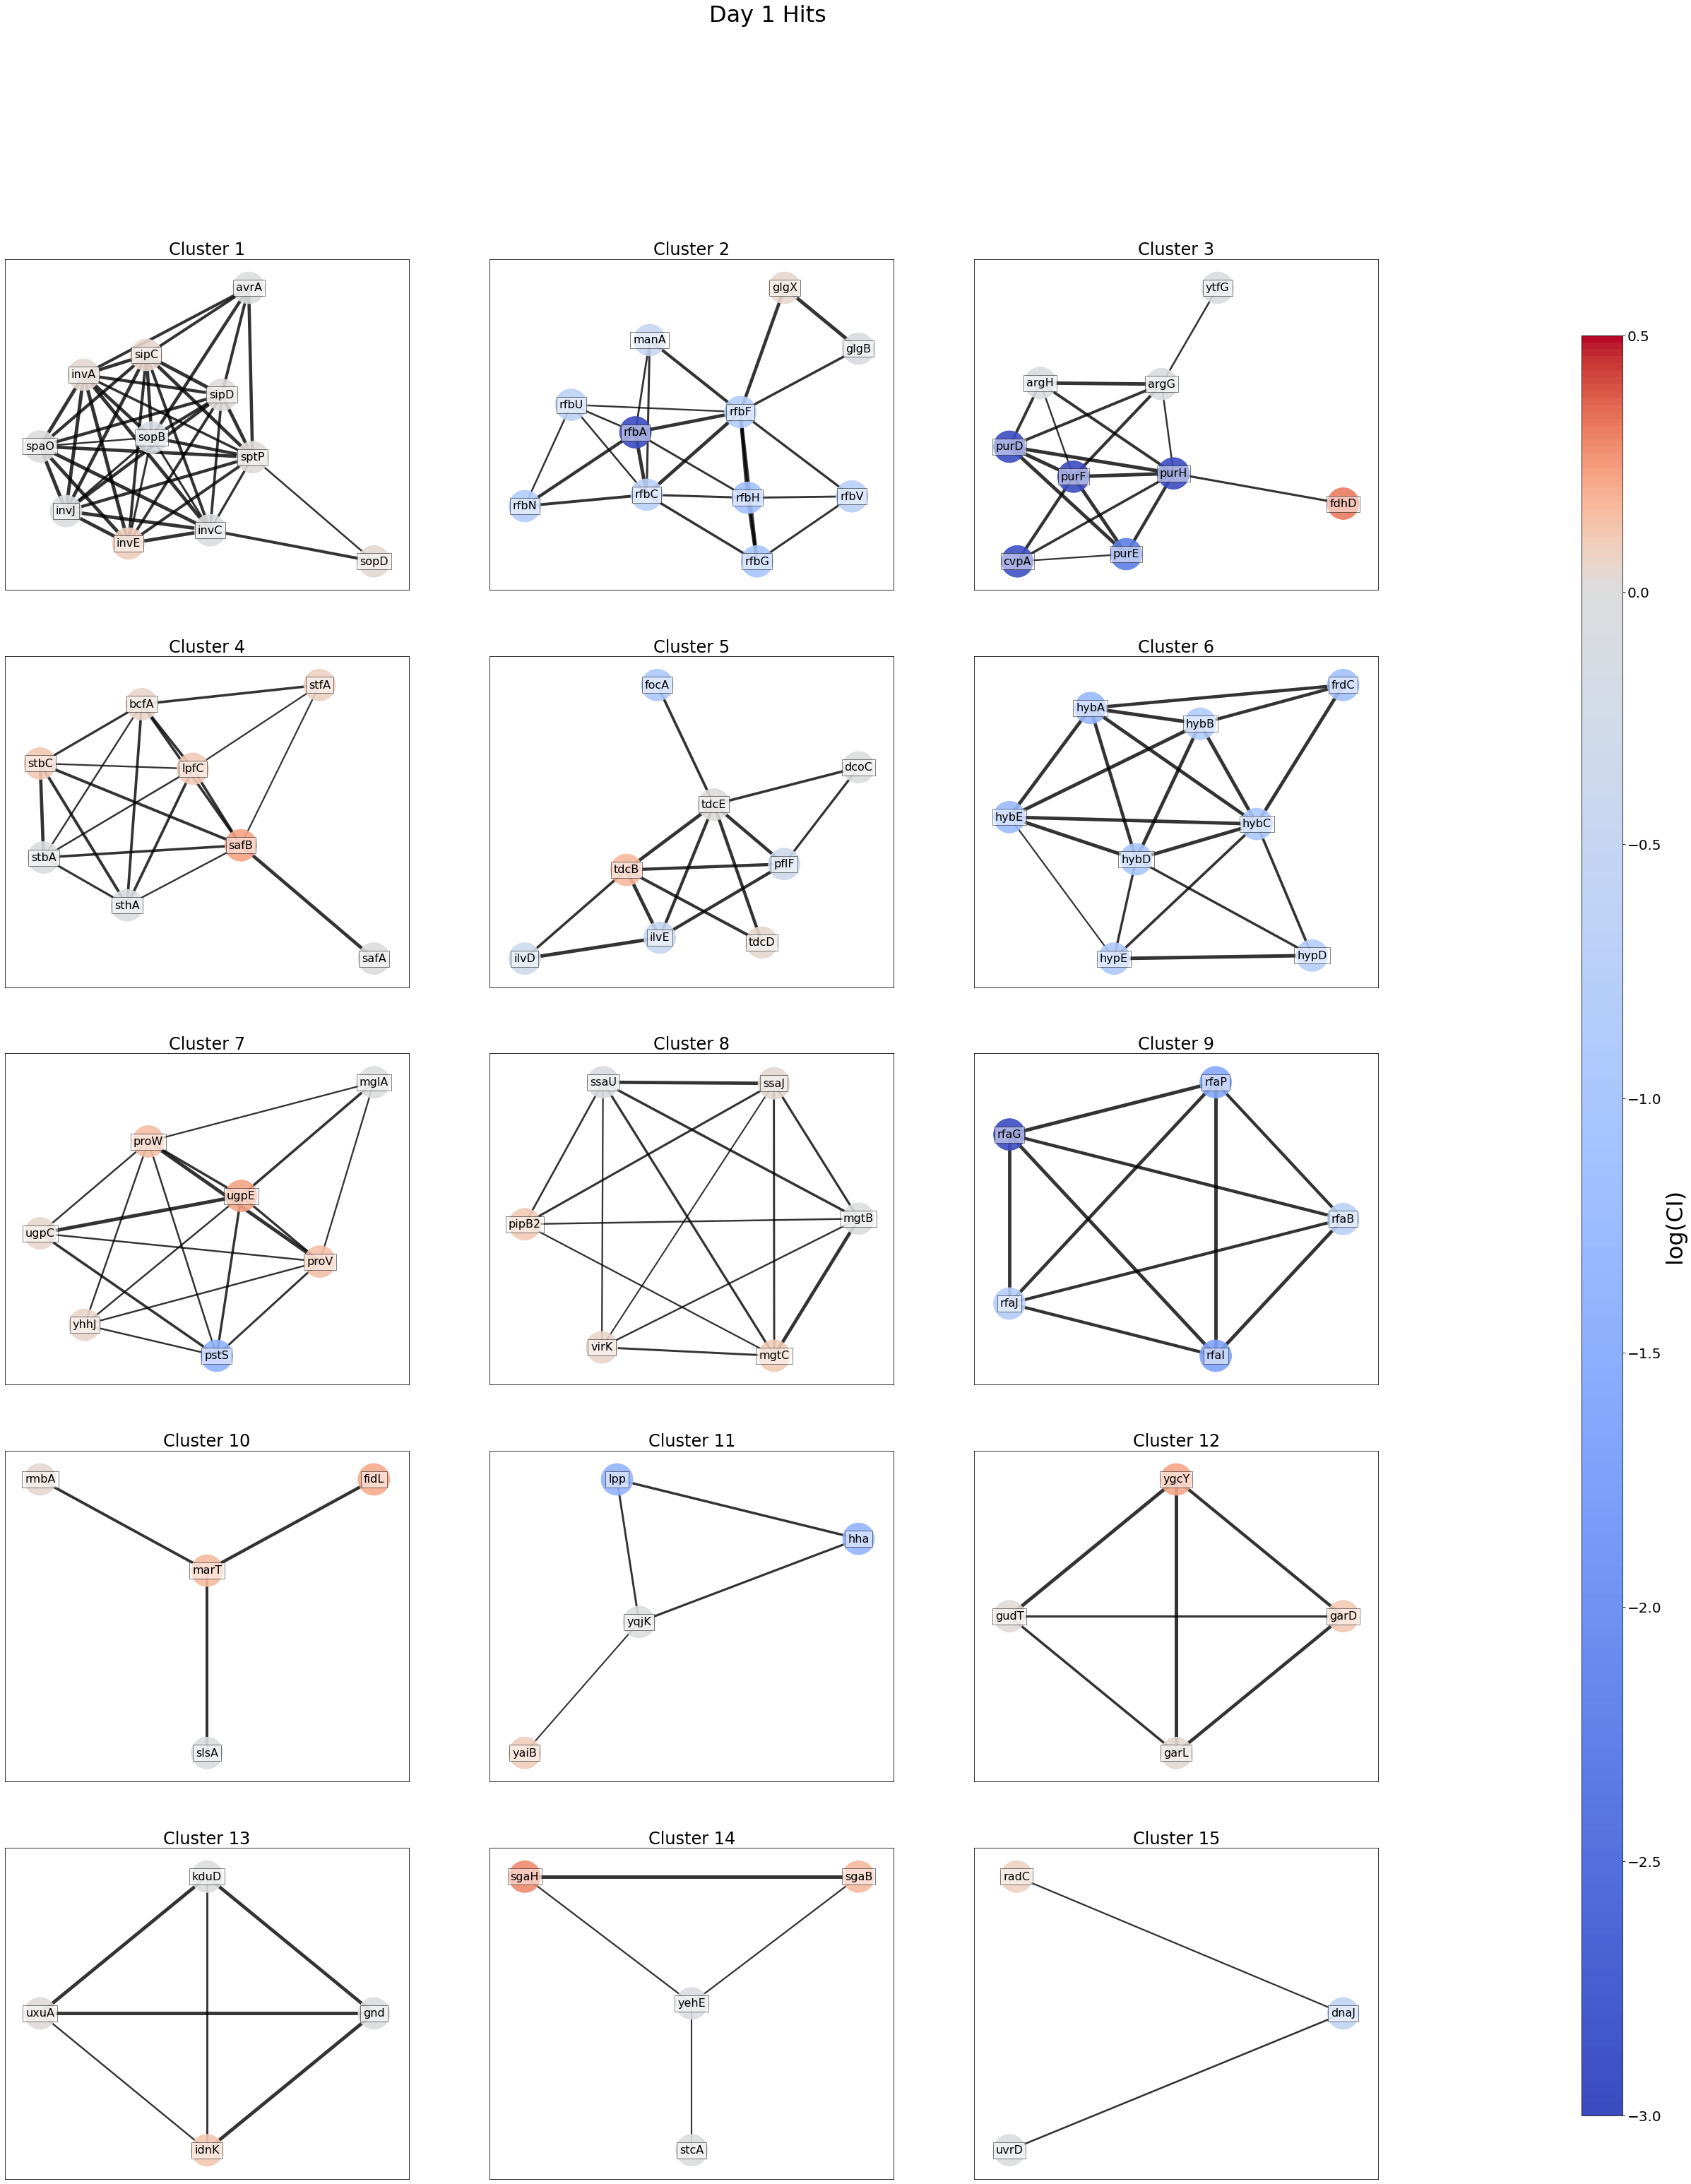

In [186]:
# Day 1

#Set up all the data

resultsDir = "../../../data/results"
day = 'd1'

ppis = pd.read_table(Path(resultsDir)/f"{day}_string_interactions_short.tsv")
ppis = ppis.rename(columns={'#node1': 'node1'})
ppis_to_graph = ppis[["node1", "node2", "combined_score"]]

ppi_clusters = pd.read_table(Path(resultsDir)/f"{day}_string_MCL_clusters.tsv")
ppi_clusters.columns = [c.replace(" ", "_") for c in ppi_clusters.columns]
ppi_cluster_dict=ppi_clusters[['protein_name', 'cluster_number']].set_index('protein_name').to_dict()['cluster_number']
day_res = results_full[results_full.day == day]
day_res = day_res.groupby('gene').CI.median().reset_index()



fig, axs = plt.subplots(5,3, figsize=(40,50))
axs = axs.flatten()

for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day=day, cluster=i+1)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+1}', fontsize=24)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cb = fig.colorbar(sm, cax=cbar_ax);
cb.ax.tick_params(labelsize=20)
cb.set_label(label='log(CI)', size=32)
# Add legend to color bar and save 
fig.suptitle("Day 1 Hits", fontsize=32)
plt.savefig(Path(resultsDir)/f"{day}-ppi-clusters.pdf")

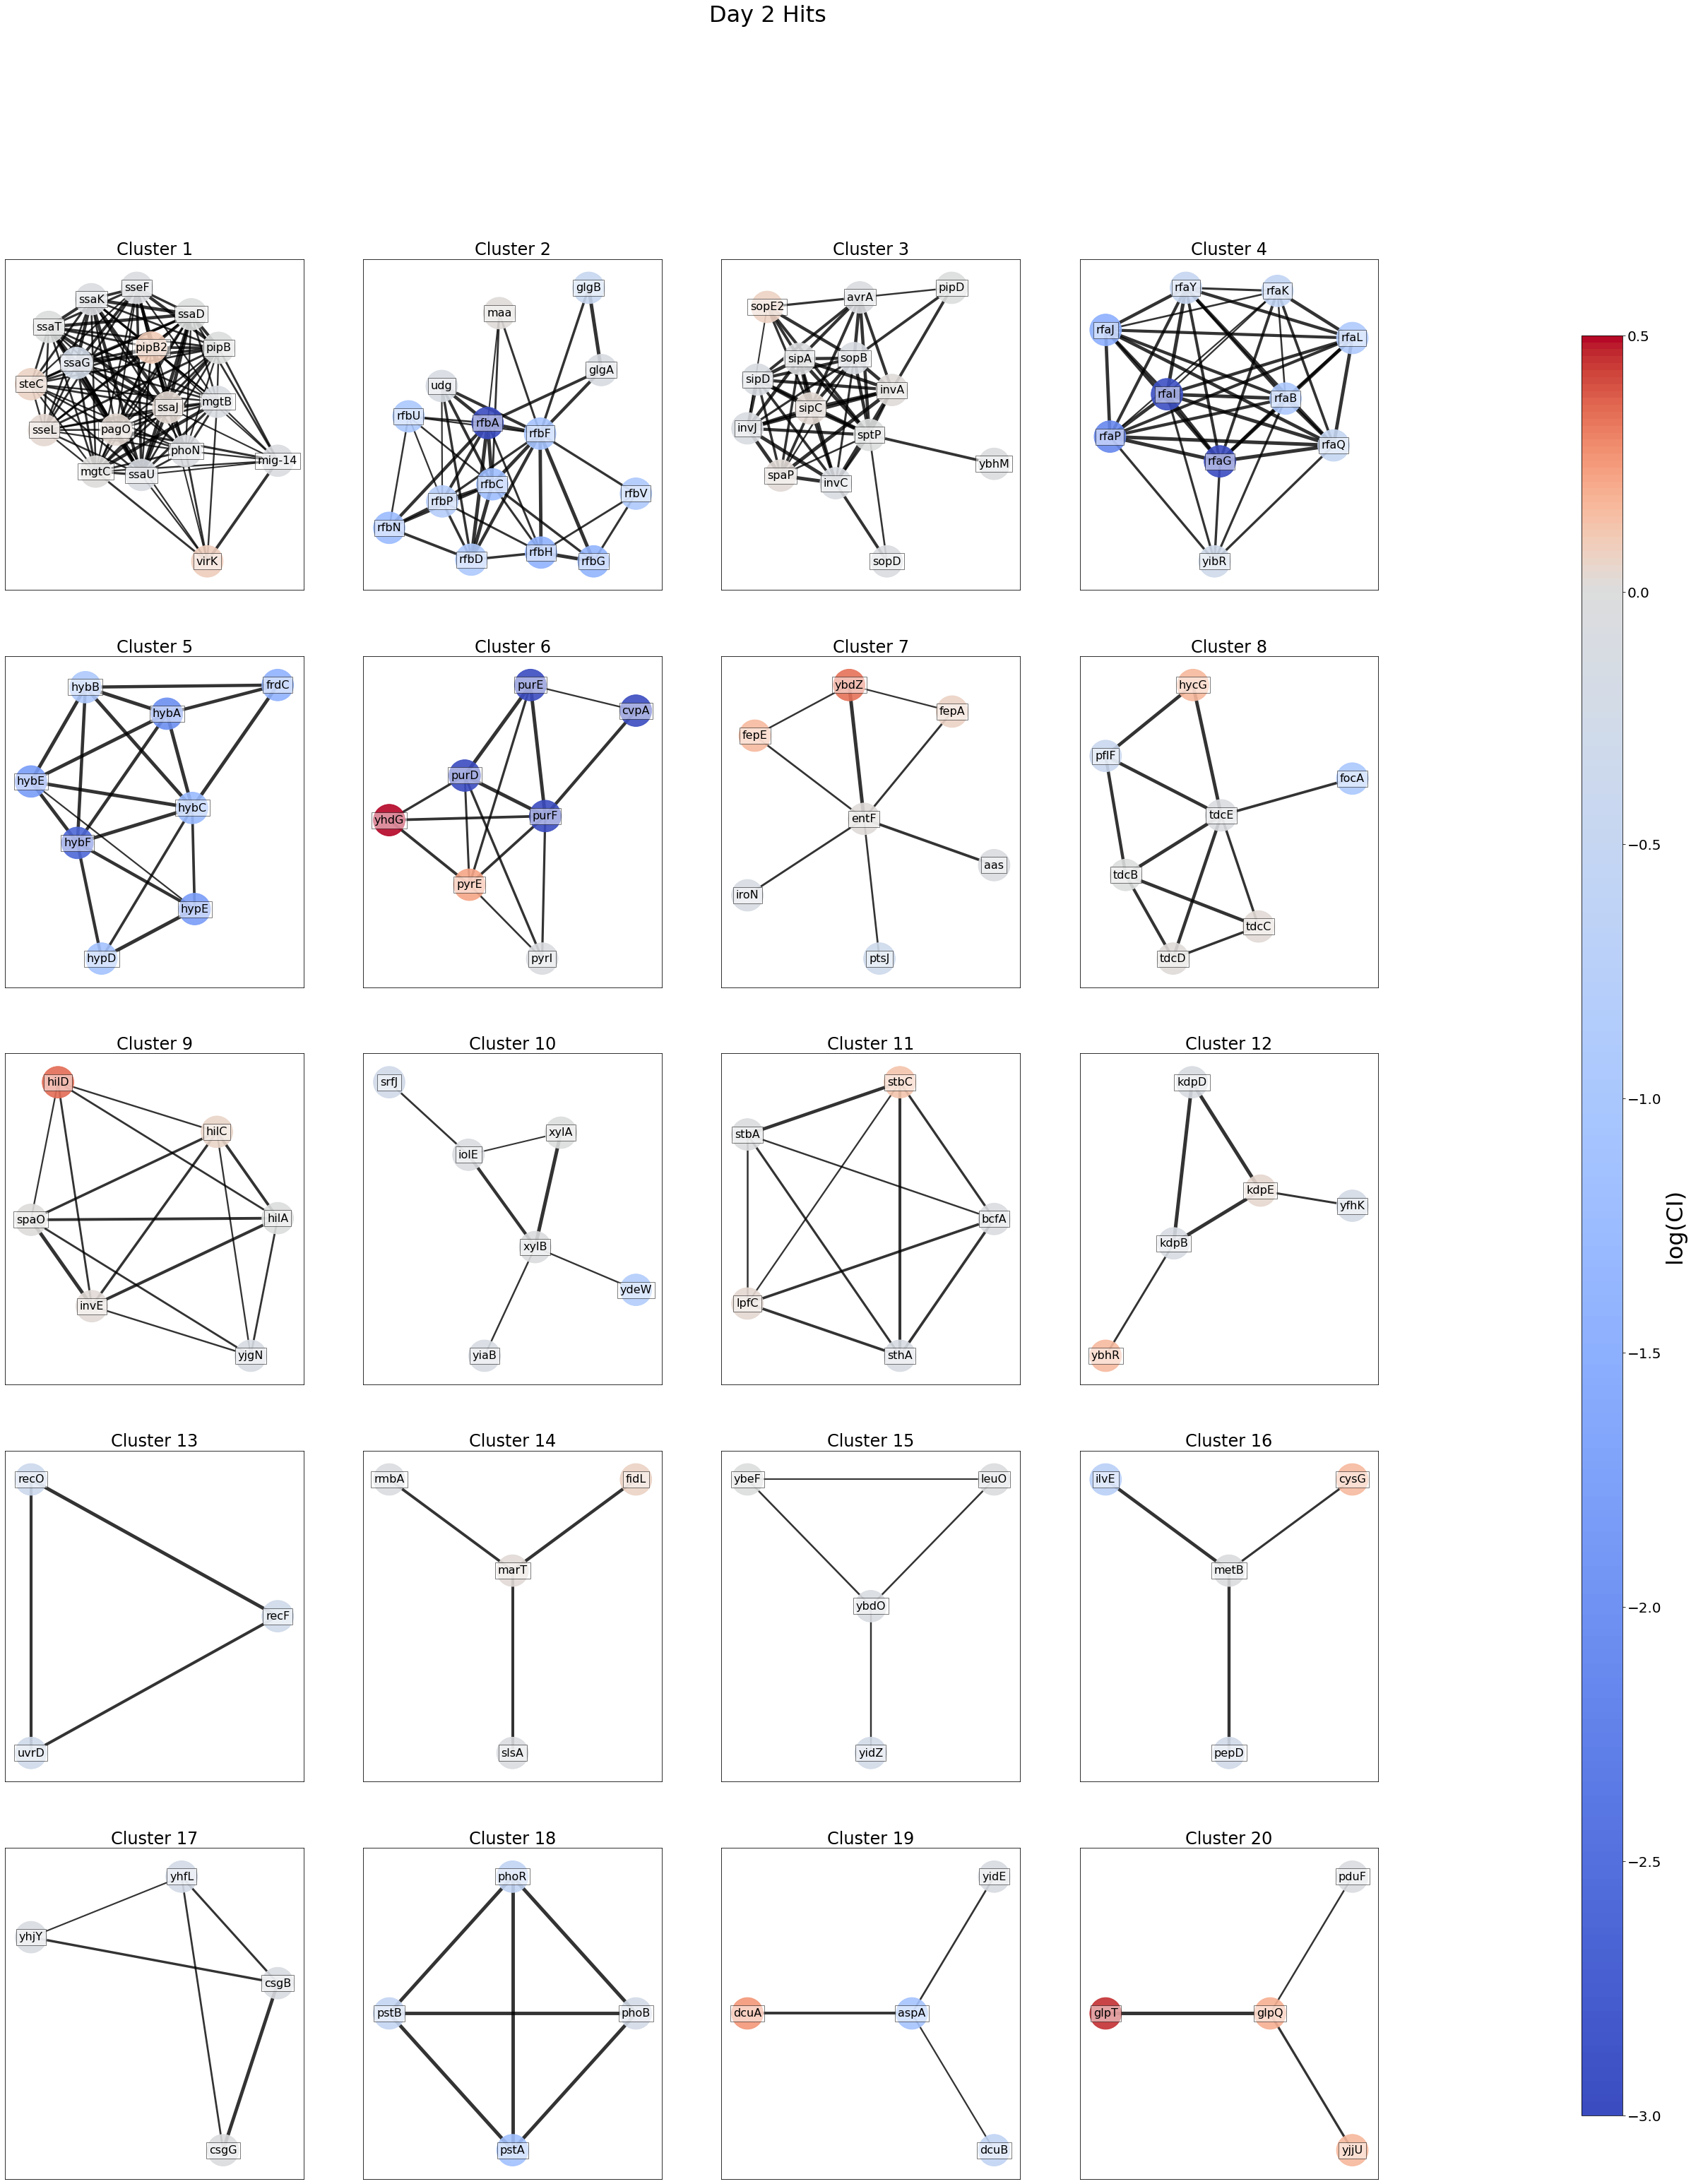

In [187]:
# Day 2

#Set up all the data

resultsDir = "../../../data/results"
day = 'd2'

ppis = pd.read_table(Path(resultsDir)/f"{day}_string_interactions_short.tsv")
ppis = ppis.rename(columns={'#node1': 'node1'})
ppis_to_graph = ppis[["node1", "node2", "combined_score"]]

ppi_clusters = pd.read_table(Path(resultsDir)/f"{day}_string_MCL_clusters.tsv")
ppi_clusters.columns = [c.replace(" ", "_") for c in ppi_clusters.columns]
ppi_cluster_dict=ppi_clusters[['protein_name', 'cluster_number']].set_index('protein_name').to_dict()['cluster_number']
day_res = results_full[results_full.day == day]
day_res = day_res.groupby('gene').CI.median().reset_index()



fig, axs = plt.subplots(5,4, figsize=(40,50))
axs = axs.flatten()

for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day=day, cluster=i+1)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+1}', fontsize=24)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cb = fig.colorbar(sm, cax=cbar_ax);
cb.ax.tick_params(labelsize=20)
cb.set_label(label='log(CI)', size=32)
# Add legend to color bar and save 
fig.suptitle("Day 2 Hits", fontsize=32)
plt.savefig(Path(resultsDir)/f"{day}-ppi-clusters.pdf")

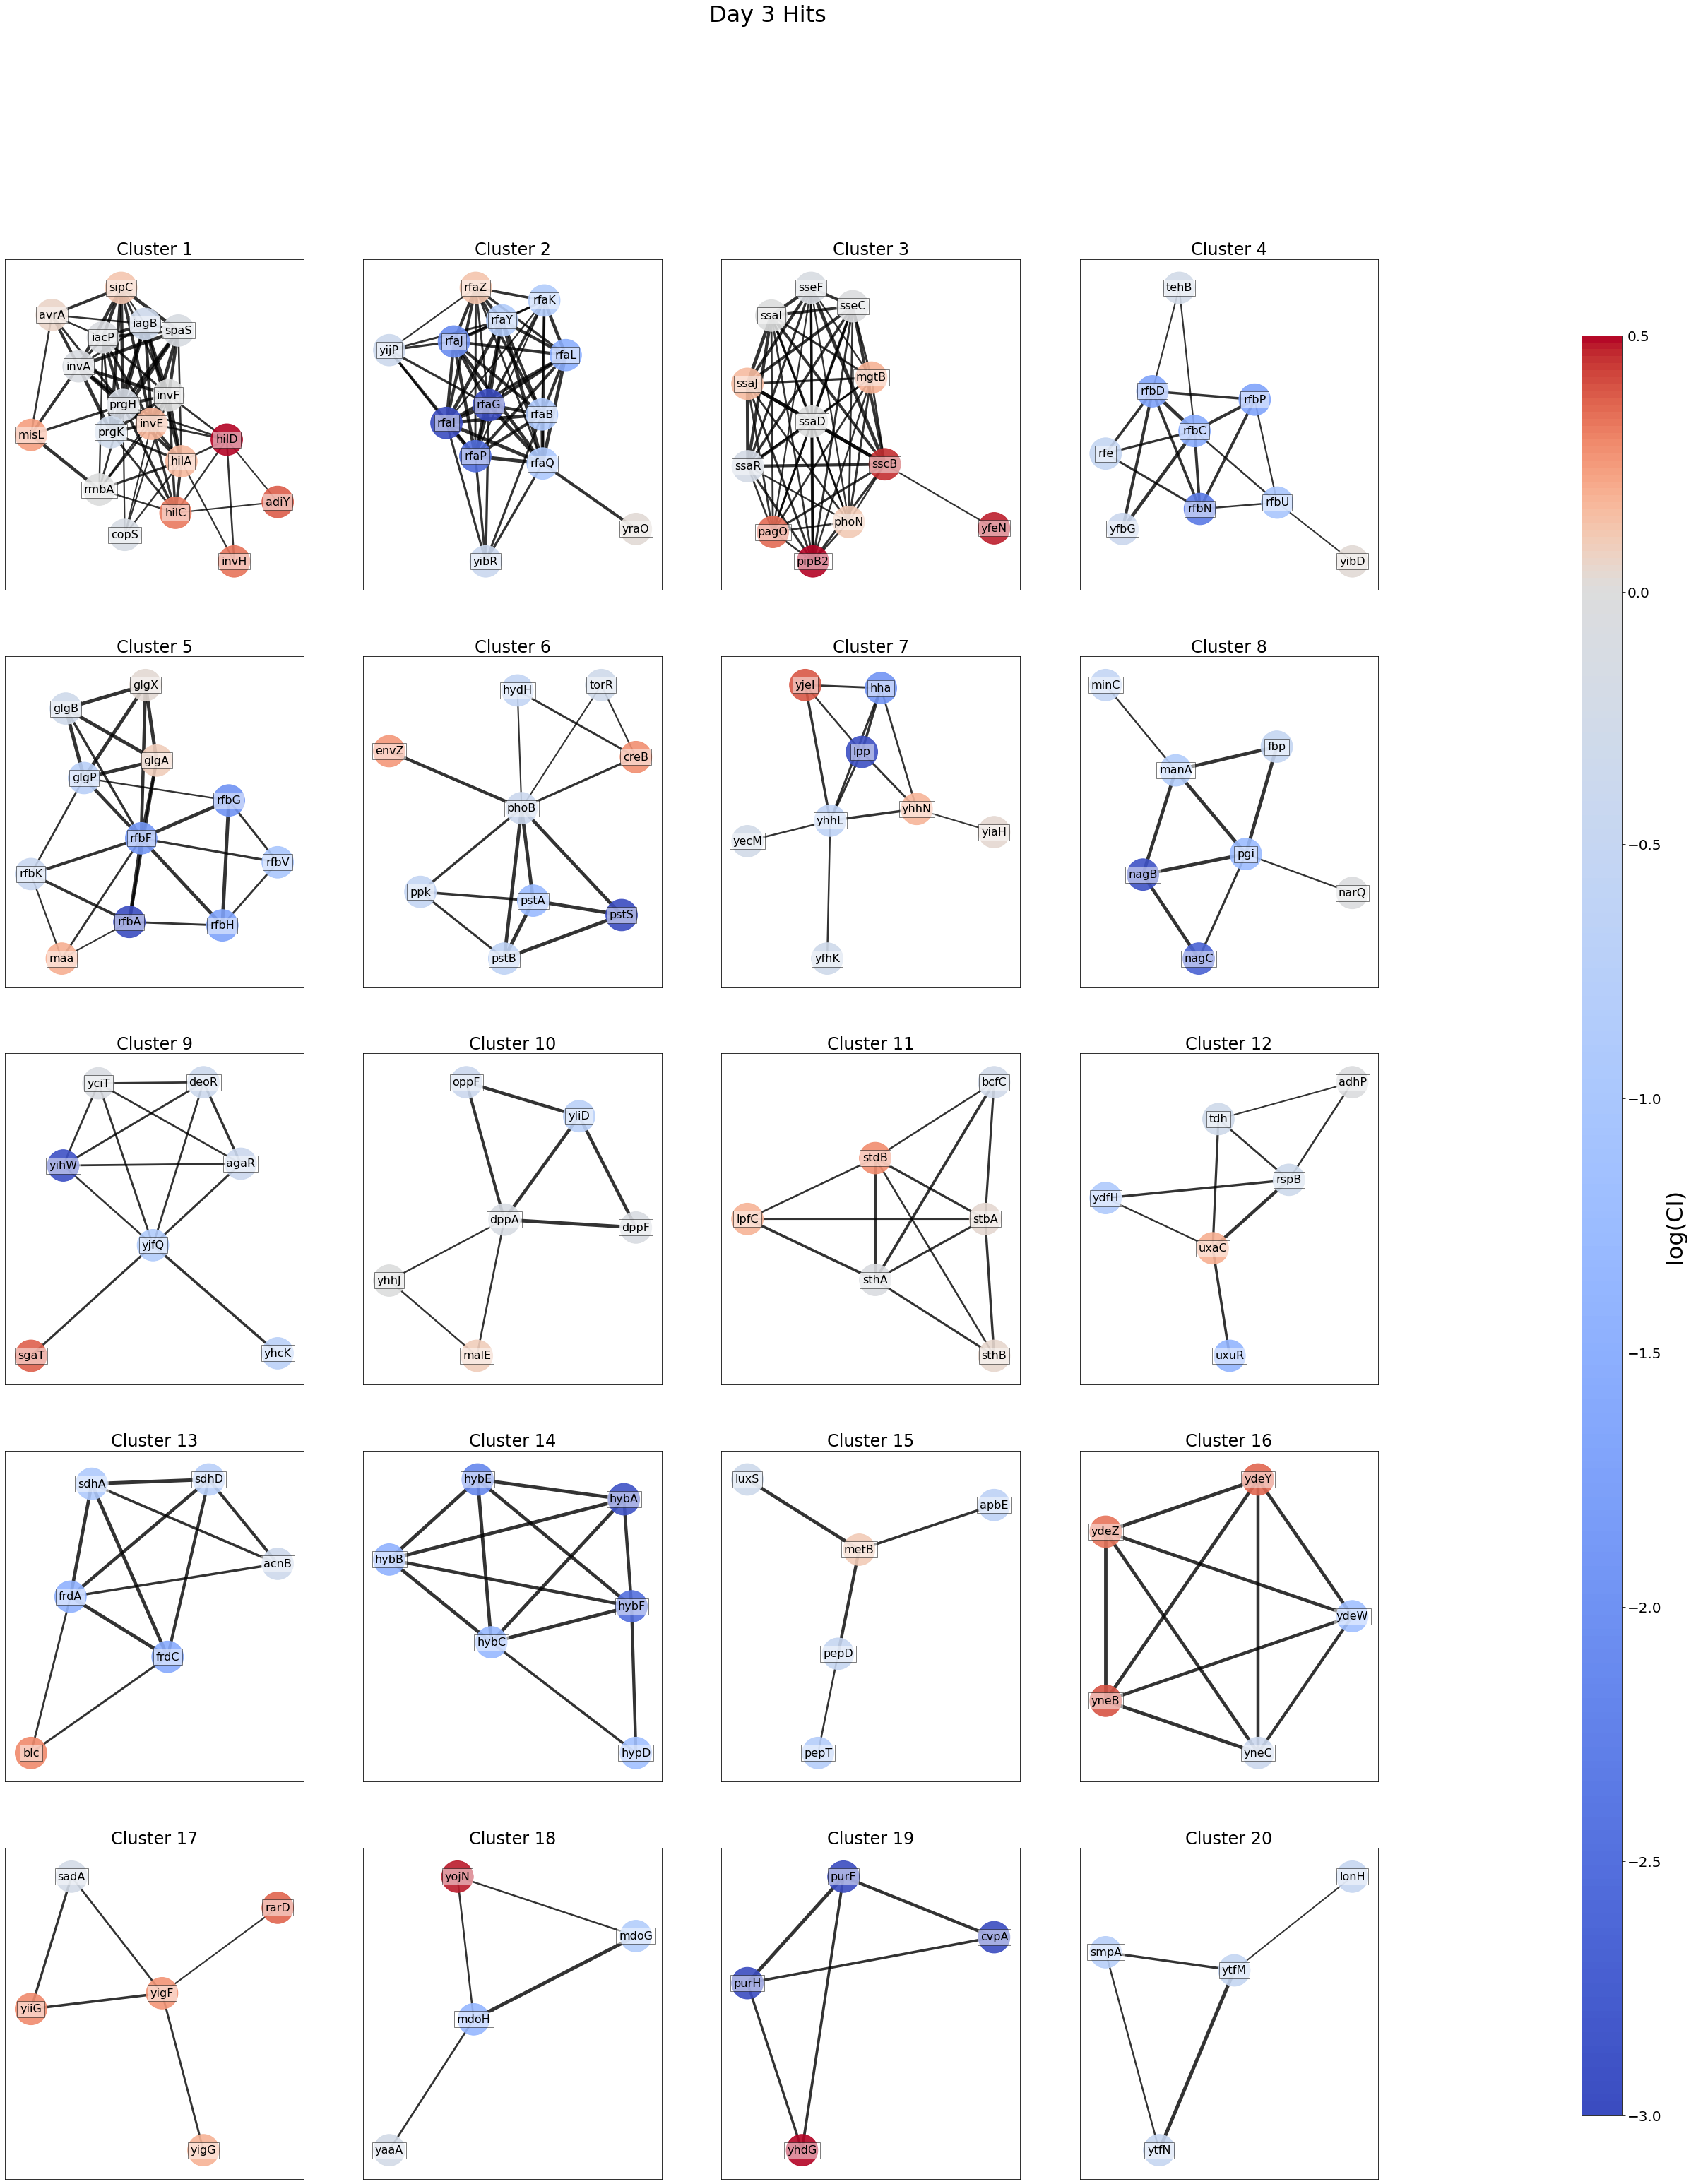

In [190]:
# Day 3

#Set up all the data

resultsDir = "../../../data/results"
day = 'd3'

ppis = pd.read_table(Path(resultsDir)/f"{day}_string_interactions_short.tsv")
ppis = ppis.rename(columns={'#node1': 'node1'})
ppis_to_graph = ppis[["node1", "node2", "combined_score"]]

ppi_clusters = pd.read_table(Path(resultsDir)/f"{day}_string_MCL_clusters.tsv")
ppi_clusters.columns = [c.replace(" ", "_") for c in ppi_clusters.columns]
ppi_cluster_dict=ppi_clusters[['protein_name', 'cluster_number']].set_index('protein_name').to_dict()['cluster_number']
day_res = results_full[results_full.day == day]
day_res = day_res.groupby('gene').CI.median().reset_index()



fig, axs = plt.subplots(5,4, figsize=(40,50))
axs = axs.flatten()

for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day=day, cluster=i+1)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+1}', fontsize=24)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cb = fig.colorbar(sm, cax=cbar_ax);
cb.ax.tick_params(labelsize=20)
cb.set_label(label='log(CI)', size=32)
# Add legend to color bar and save 
fig.suptitle("Day 3 Hits", fontsize=32)
plt.savefig(Path(resultsDir)/f"{day}-ppi-clusters.pdf")

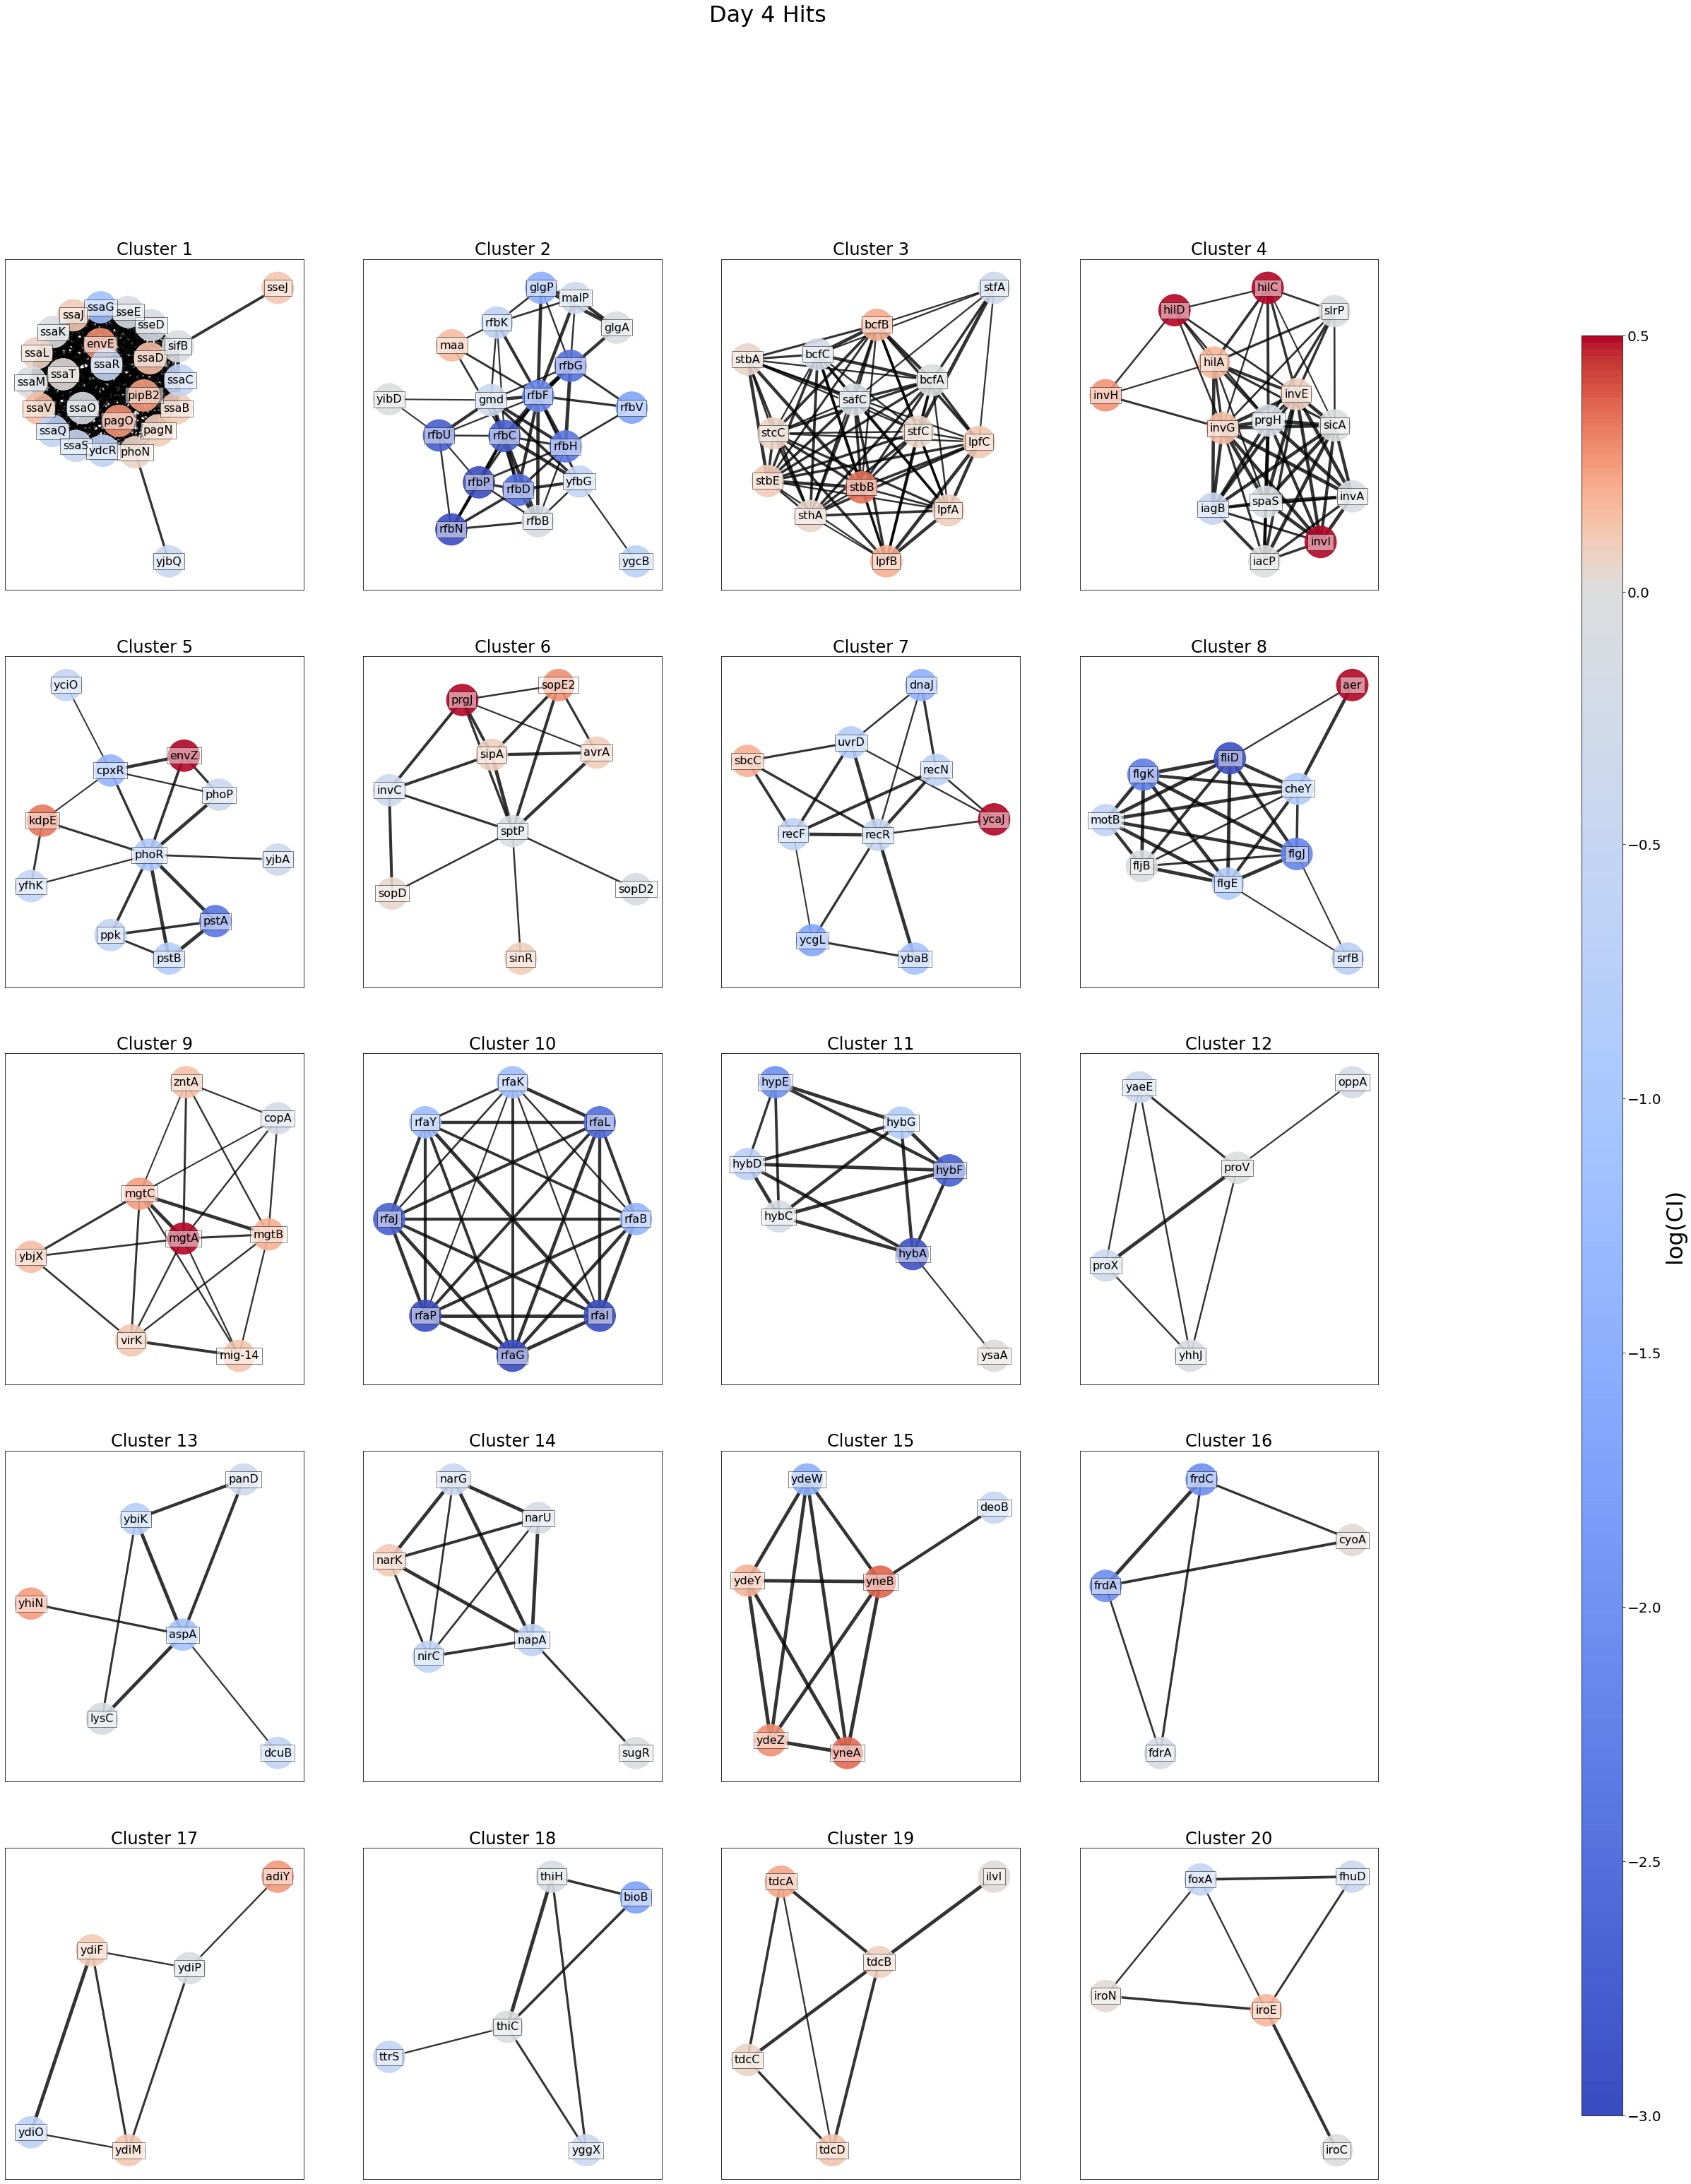

In [191]:
# Day 4

#Set up all the data

resultsDir = "../../../data/results"
day = 'd4'

ppis = pd.read_table(Path(resultsDir)/f"{day}_string_interactions_short.tsv")
ppis = ppis.rename(columns={'#node1': 'node1'})
ppis_to_graph = ppis[["node1", "node2", "combined_score"]]

ppi_clusters = pd.read_table(Path(resultsDir)/f"{day}_string_MCL_clusters.tsv")
ppi_clusters.columns = [c.replace(" ", "_") for c in ppi_clusters.columns]
ppi_cluster_dict=ppi_clusters[['protein_name', 'cluster_number']].set_index('protein_name').to_dict()['cluster_number']
day_res = results_full[results_full.day == day]
day_res = day_res.groupby('gene').CI.median().reset_index()



fig, axs = plt.subplots(5,4, figsize=(40,50))
axs = axs.flatten()

for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day=day, cluster=i+1)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+1}', fontsize=24)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cb = fig.colorbar(sm, cax=cbar_ax);
cb.ax.tick_params(labelsize=20)
cb.set_label(label='log(CI)', size=32)
# Add legend to color bar and save 
fig.suptitle("Day 4 Hits", fontsize=32)
plt.savefig(Path(resultsDir)/f"{day}-ppi-clusters.pdf")

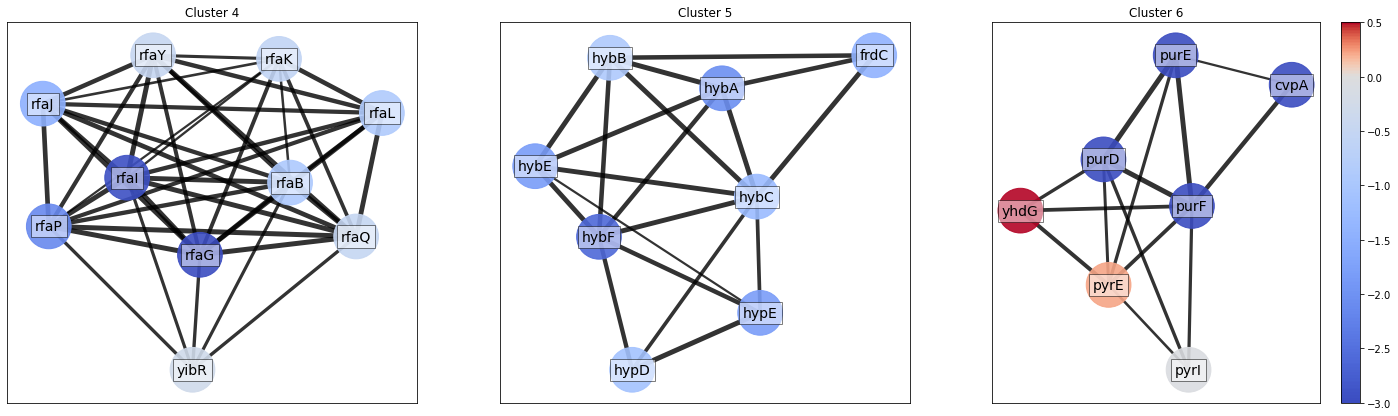

In [127]:
fig2, axs = plt.subplots(1,3, figsize=(25,7))
for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day='d2', cluster=i+4)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+4}')
plt.colorbar(sm);

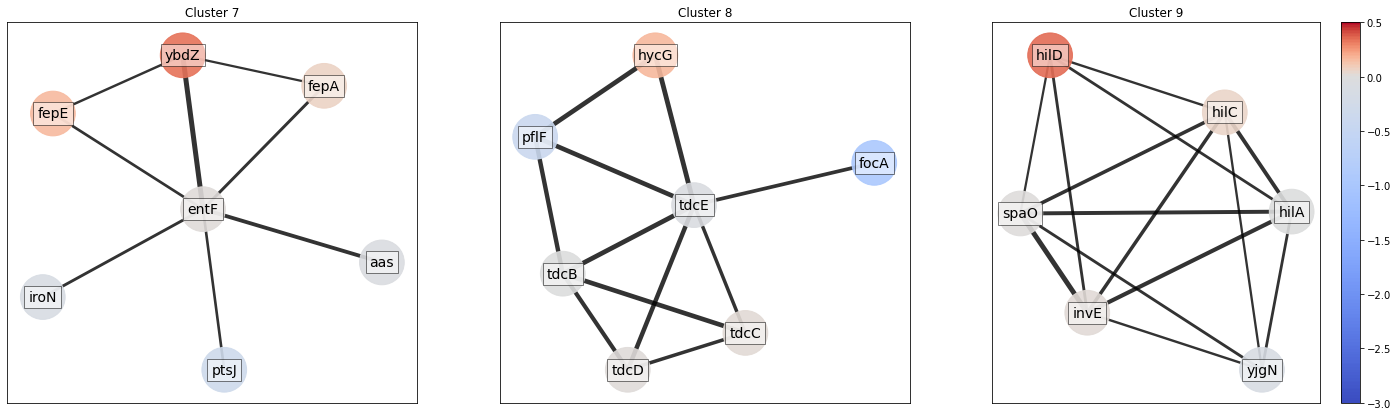

In [128]:
fig3, axs = plt.subplots(1,3, figsize=(25,7))
for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day='d2', cluster=i+7)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+7}')
plt.colorbar(sm);

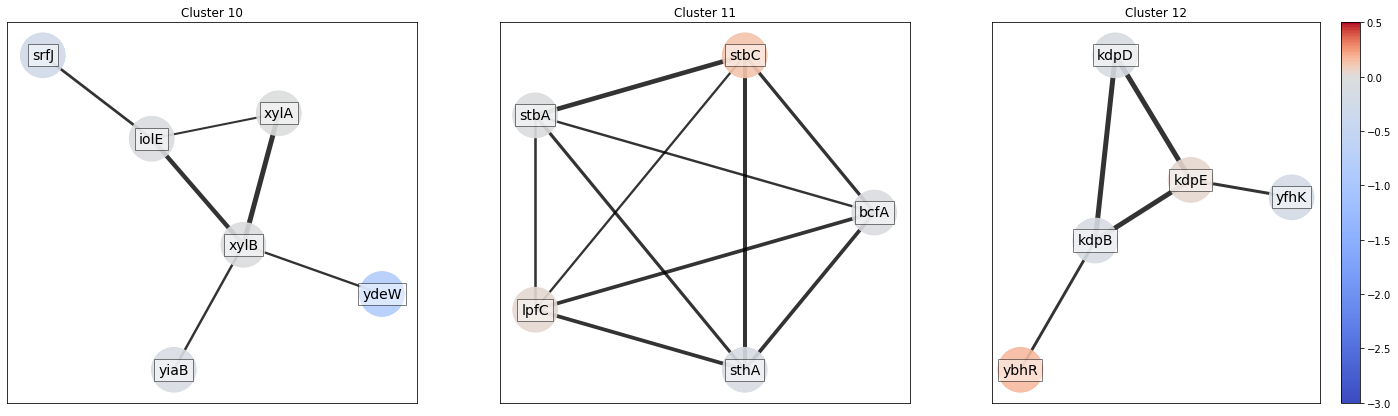

In [129]:
fig4, axs = plt.subplots(1,3, figsize=(25,7))
for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day='d2', cluster=i+10)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+10}')
plt.colorbar(sm);

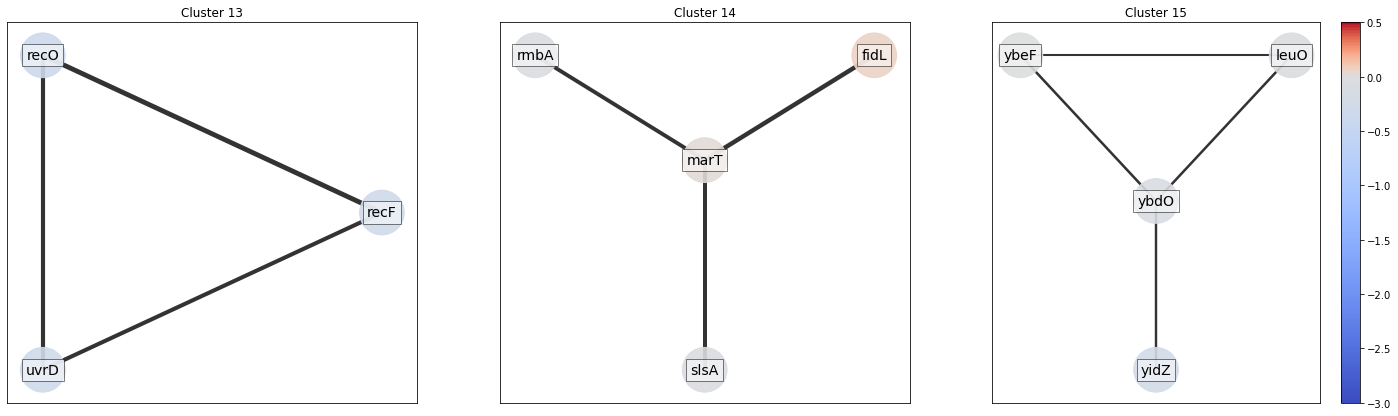

In [130]:
fig5, axs = plt.subplots(1,3, figsize=(25,7))
for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day='d2', cluster=i+13)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+13}')
plt.colorbar(sm);

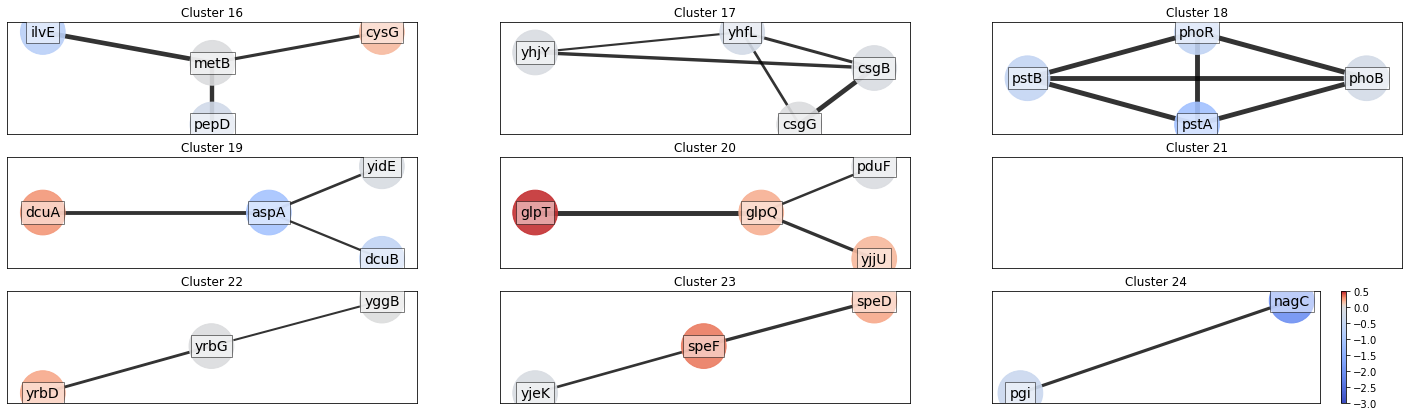

In [143]:
fig6, axs = plt.subplots(3,3, figsize=(25,7))
axs = axs.flatten()
for i, ax in enumerate(axs):
    G = get_graph_for_cluster(results_full, ppi_clusters, ppis, day='d2', cluster=i+16)
    plot_cluster(G, ax, sm)
    ax.set_title(f'Cluster {i+16}')
plt.colorbar(sm);

In [141]:
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
for fig in range(1,plt.figure().number): ## will open an empty extra figure :(
    print(fig)

<Figure size 432x288 with 0 Axes>

In [140]:
plt.figure().number

1

<Figure size 432x288 with 0 Axes>

In [87]:
ppi_clusters[ppi_clusters.cluster_number == 9]

#clustering_method  cluster_number cluster_color  gene_count protein_name  \
88                MCL               9  Fire Brick 4           6         hilA   
89                MCL               9  Fire Brick 4           6         hilC   
90                MCL               9  Fire Brick 4           6         hilD   
91                MCL               9  Fire Brick 4           6         invE   
92                MCL               9  Fire Brick 4           6         spaO   
93                MCL               9  Fire Brick 4           6         yjgN   

   protein_identifier                                protein_description  
88      99287.STM2876  Transcriptional regulator HilA; The main trans...  
89      99287.STM2867  Transcriptional regulator sirC; Positive regul...  
90      99287.STM2875  Transcriptional regulator HilD; HilD (gi|4455108)  
91      99287.STM2897  Invasion protein InvE; Involved in the trigger...  
92      99287.STM2891  Surface presentation of antigens protein SpaO;...  
93      99287.STM4474  Inner membrane protein YjgN; Hypothetical prot...

In [67]:
ppi_clusters[ppi_clusters['gene_count'] > 5].drop_duplicates()

#clustering_method  cluster_number cluster_color  gene_count protein_name  \
0                 MCL               1           Red          18      STM1397   
1                 MCL               1           Red          18         mgtB   
2                 MCL               1           Red          18         mgtC   
3                 MCL               1           Red          18       mig-14   
4                 MCL               1           Red          18         pagO   
..                ...             ...           ...         ...          ...   
95                MCL              10         Brown           6         srfJ   
96                MCL              10         Brown           6         xylA   
97                MCL              10         Brown           6         xylB   
98                MCL              10         Brown           6         ydeW   
99                MCL              10         Brown           6         yiaB   

   protein_identifier                                protein_description  
0       99287.STM1397  Type III secretion system chaperone SseA; Func...  
1       99287.STM3763  Magnesium-transporting ATPase, P-type 1; Media...  
2       99287.STM3764  Protein MgtC; Virulence factor required for gr...  
3       99287.STM2782                   Putative transcription activator  
4       99287.STM1862  Protein PagO; Predicted integral membrane prot...  
..                ...                                                ...  
95      99287.STM4426  Activated by transcription factor SsrB; Simila...  
96      99287.STM3661  Similar to E. coli D-xylose isomerase (AAC7658...  
97      99287.STM3660  Xylulose kinase; Similar to E. coli xylulokina...  
98      99287.STM4073  Transcriptional regulator LsrR; In the absence...  
99      99287.STM3659  Putative inner membrane protein; Similar to E....  

[100 rows x 7 columns]